<a href="https://colab.research.google.com/github/tomonari-masada/course2022-stats1/blob/main/MLE_for_binomial_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchによる二項分布の最尤推定

In [1]:
import matplotlib.pyplot as plt
import torch
%config InlineBackend.figure_format='retina'

## PyTorchを使った二項分布の作り方

* 以下、コイン投げの言葉を使って説明する。

* 総試行回数$N$と表が出る確率$\phi$の値を指定すると、二項分布を一つ選ぶことになる。

### 例１
* $N=100, \phi=0.1$と設定した二項分布で、表が52回出たという観測データの対数尤度を求める。

In [2]:
N = 100
K = 52
phi = 0.1

In [3]:
m = torch.distributions.binomial.Binomial(N, probs=phi)
print(m.log_prob(torch.tensor([K])).item())
print(m.log_prob(torch.tensor([K])).exp().item())

-58.08709716796875
5.93053980520853e-26


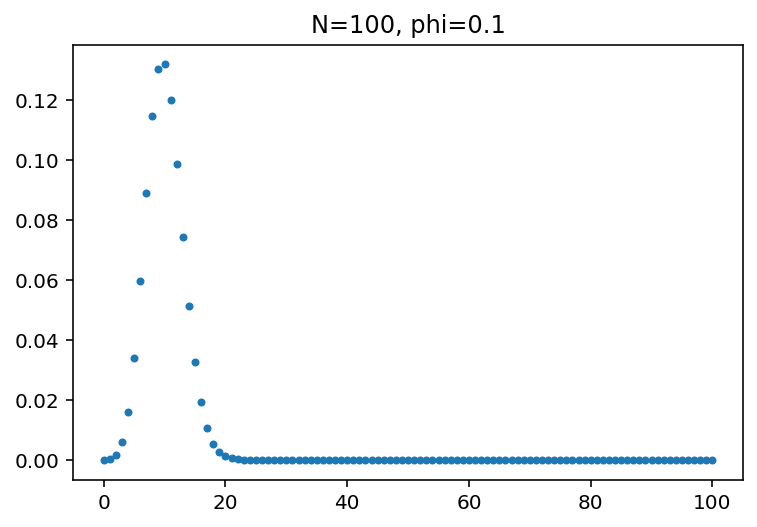

In [4]:
x = range(N + 1)
plt.plot(x, m.log_prob(torch.tensor(x)).exp().numpy(), '.')
plt.title(f"N={N}, phi={phi}");

### 例2
* $N=100, \phi=0.5$と設定した二項分布で、表が52回出たという観測データの対数尤度を求める。

In [5]:
N = 100
K = 52
phi = 0.5

In [6]:
m = torch.distributions.binomial.Binomial(N, probs=phi)
print(m.log_prob(torch.tensor([K])).item())
print(m.log_prob(torch.tensor([K])).exp().item())

-2.610107421875
0.07352664321660995


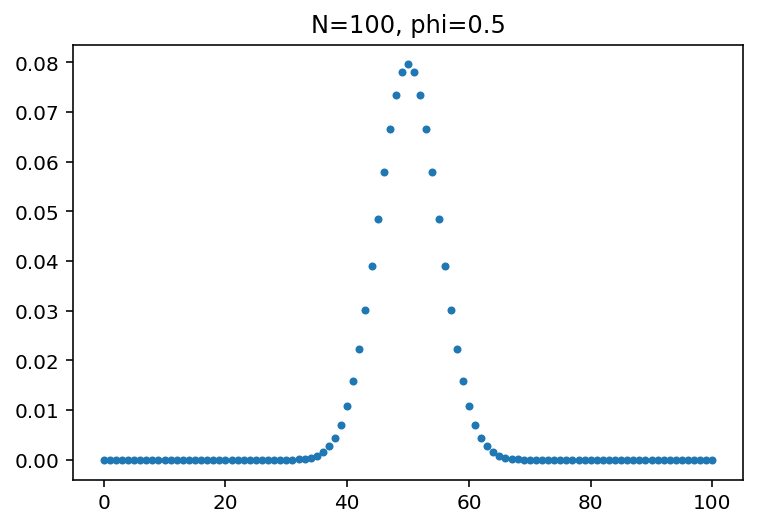

In [7]:
x = range(N + 1)
plt.plot(x, m.log_prob(torch.tensor(x)).exp().numpy(), '.')
plt.title(f"N={N}, phi={phi}");

* 表の出た回数が52回であれば、一つ目より2つ目のモデルが、データ尤度を大きくしていると分かる。
* では、データ尤度を最大にする二項分布モデルのパラメータ$\phi$は、いくらだろうか？

## 対数尤度最大化をPyTorchで実装

* 二項分布のパラメータは、微分可能なテンソルとして作っておく。
* そして、そのパラメータを更新するoptimizerを作る。

In [8]:
N = 100
K = 52

In [9]:
phi = torch.tensor([0.232], requires_grad=True) # 適当な値に初期化
optimizer = torch.optim.SGD([phi], lr=0.001) # 最適化アルゴリズムはSGD

* negative log likelihoodを最小化する。
 * PyTorchでは最小化の計算しかできないので、最大化したいときは、マイナスを付けたものを最小化する。

In [10]:
for i in range(30):
  optimizer.zero_grad()
  m = torch.distributions.binomial.Binomial(N, probs=phi)
  loss = - m.log_prob(torch.tensor([K]))
  loss.backward()
  optimizer.step()
  print(f"{i+1} | {phi.item():.4f}")

1 | 0.3936
2 | 0.4466
3 | 0.4763
4 | 0.4938
5 | 0.5043
6 | 0.5106
7 | 0.5143
8 | 0.5166
9 | 0.5180
10 | 0.5188
11 | 0.5193
12 | 0.5196
13 | 0.5197
14 | 0.5198
15 | 0.5199
16 | 0.5199
17 | 0.5200
18 | 0.5200
19 | 0.5200
20 | 0.5200
21 | 0.5200
22 | 0.5200
23 | 0.5200
24 | 0.5200
25 | 0.5200
26 | 0.5200
27 | 0.5200
28 | 0.5200
29 | 0.5200
30 | 0.5200


# TensorFlowによる二項分布の最尤推定

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp

In [12]:
N = 100
K = 52

In [13]:
phi = tf.Variable(0.232) # 適当に初期化
opt = tf.optimizers.SGD(learning_rate=0.001)

In [14]:
m = tfp.distributions.Binomial(N, probs=phi)
for i in range(30):
  loss = lambda: - m.log_prob(K)
  opt.minimize(loss, var_list=[phi])
  print(f"{i+1} | {phi.numpy():.4f}")

1 | 0.3936
2 | 0.4466
3 | 0.4763
4 | 0.4938
5 | 0.5043
6 | 0.5106
7 | 0.5143
8 | 0.5166
9 | 0.5180
10 | 0.5188
11 | 0.5193
12 | 0.5196
13 | 0.5197
14 | 0.5198
15 | 0.5199
16 | 0.5199
17 | 0.5200
18 | 0.5200
19 | 0.5200
20 | 0.5200
21 | 0.5200
22 | 0.5200
23 | 0.5200
24 | 0.5200
25 | 0.5200
26 | 0.5200
27 | 0.5200
28 | 0.5200
29 | 0.5200
30 | 0.5200


# NumPyroによる二項分布の最尤推定

In [15]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 8.8 MB/s 


In [16]:
import numpy as np
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO

In [17]:
N = 100
K = 52

In [18]:
def model(data):
  f = numpyro.param("phi", np.array(0.232))
  numpyro.sample("obs", dist.Binomial(N, f), obs=data)

numpyro.render_model(model, model_args=(K,),
                     render_distributions=True, render_params=True)

def guide(data):
  pass

In [19]:
opt = numpyro.optim.SGD(step_size=0.001)
svi = SVI(model, guide, opt, loss=Trace_ELBO())
svi_state = svi.init(random.PRNGKey(0), K)
for i in range(30):
  svi_state, loss = svi.update(svi_state, K)
  print(f"{i+1} | {svi.get_params(svi_state)['phi']:.4f}")

1 | 0.3936
2 | 0.4466
3 | 0.4763
4 | 0.4938
5 | 0.5043
6 | 0.5106
7 | 0.5143
8 | 0.5166
9 | 0.5180
10 | 0.5188
11 | 0.5193
12 | 0.5196
13 | 0.5197
14 | 0.5198
15 | 0.5199
16 | 0.5199
17 | 0.5200
18 | 0.5200
19 | 0.5200
20 | 0.5200
21 | 0.5200
22 | 0.5200
23 | 0.5200
24 | 0.5200
25 | 0.5200
26 | 0.5200
27 | 0.5200
28 | 0.5200
29 | 0.5200
30 | 0.5200
